In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

In [2]:
fpath = 'data/prep/'
dfile = 'form_data_v2.0.csv'

In [3]:
df = pd.read_csv( fpath + dfile, header=0, parse_dates=True )

In [7]:
# flat races
df = df[df.Type.isna()]

In [11]:
df = df[df.RaceName.apply(lambda x: "Queen's Vase" in x)]

AttributeError: 'DataFrame' object has no attribute 'RaceName'

In [13]:
df.columns

Index(['RaceId', 'CourseName', 'RaceDate', 'RaceTime', 'Type', 'Class',
       'Prize', 'FieldSize', 'Distance', 'RaceWinTime', 'Posn', 'TotalBtn',
       'HorseName', 'Draw', 'Sp', 'WeightLBS', 'Aid', 'Trainer', 'Jockey',
       'Allow', 'OR', 'Comments', 'Territory', 'RT', 'AgeMin', 'AgeMax', 'AW',
       'Going1', 'Going1N', 'Won', 'Placed', 'ReturnWin', 'ReturnPlace'],
      dtype='object')

In [33]:
# remove entries with missing Draw - some of these could be imputed or manually entered
# print(df.RaceId[df.Draw.isna()].unique())
df = df[~df.Draw.isna()]

In [34]:
# no. declared from max draw by race, ie FieldSize + RR + withdrawn
DeclFieldSize = df[['RaceId', 'Draw']].groupby('RaceId').max().squeeze().rename('DeclFieldSize').astype(int)
df = df.join(DeclFieldSize, on='RaceId')

In [35]:
# rank of draw by race
df['DrawRank'] = df[['RaceId', 'Draw']].groupby('RaceId').rank('first').astype(int)

In [36]:
# no. stalls from max draw rank by race ( ==FieldSize ?? == grouby count ?? )
N_Stalls = df[['RaceId', 'DrawRank']].groupby('RaceId').max().squeeze().rename('N_Stalls').astype(int)
df = df.join(N_Stalls, on='RaceId')

In [37]:
# df[df.FieldSize != df.N_Stalls][['RaceId','FieldSize','DeclFieldSize','N_Stalls']]

In [14]:
# replace non-numeric Posn with last place and cast to int
df['Posn'] = df.apply(lambda r: int(r.Posn) if r.Posn.isnumeric() else r.DeclFieldSize, axis=1)

In [141]:
def xmast(data, course_name, dist=None, going=None, stalls='inside', min_ave_supp=3):
    if dist:
        # round to nearest half-furlong
        dist = list(np.round(np.array(dist) / 110) * 110)
        dist_mask = data.Distance != data.Distance
        for dist_ in dist:
            dist_mask = dist_mask | data.Distance.apply(lambda x: (x>dist_-55) & (x<dist_+55))
    else:
        dist_mask = True
    if going:
        going_mask = data.Going1.apply(lambda x: x in going)
    else:
        going_mask = True
    dat = data[(data.CourseName==course_name) & dist_mask & going_mask]
    dat = pd.DataFrame({'N_Stalls': dat.N_Stalls, 
                        'DrawRank': dat.DrawRank.apply(int),
                        # TODO index options as argument
                        'Index': dat.apply(lambda r: r.ReturnWin * 2 if r.Sp < 7.5 else r.ReturnWin+r.ReturnPlace, axis=1)
                       })
    # TODO add other indexes as (string) options
    # create tables
    g = dat[['N_Stalls','DrawRank','Index']].groupby(['N_Stalls','DrawRank'])
    dat_sum = g.sum()
    dat_n = g.count()
    dat_sum = dat_sum.reset_index().pivot_table(index='N_Stalls',columns='DrawRank').fillna(0)
    dat_n = dat_n.reset_index().pivot_table(index='N_Stalls',columns='DrawRank').fillna(0)
    dat_sum.columns = dat_sum.columns.droplevel(0)
    dat_n.columns = dat_n.columns.droplevel(0)
    # aggregate to min_ave_supp
    min_fieldsize = dat_n.index.values.min()
    max_draw = dat_n.columns.values.max()
    dat_0 = pd.DataFrame(np.zeros([max_draw, max_draw]), index=np.arange(1,max_draw+1), columns=np.arange(1,max_draw+1))    
    dat_sum = (dat_sum + dat_0).fillna(0)
    dat_n = (dat_n  + dat_0).fillna(0) # NB. loses index name 'N_Stalls'    
    # # debugging
    dat_n_0 = dat_n.copy()
    dat_sum_0 = dat_sum.copy()
    dat_n = dat_n_0.copy()
    dat_sum = dat_sum_0.copy()
    row_idx = 0
    
    while ~np.all(dat_n.sum(axis=1) / dat_n.index.values >= min_ave_supp):
        # aggregate from top or bottom ?
        a = dat_n.index[dat_n.sum(axis=1) / dat_n.index.values < min_ave_supp].values
        row_idx = int(sum(a < len(dat_n)/2) > len(a)/2) - 1
        # # debugging
        # print(dat_n.sum(axis=1) / dat_n.index.values >= min_ave_supp)
        # print(row_idx)
        # print()
        vec1_n = dat_n.iloc[row_idx,:dat_n.index[row_idx]].values
        vec1_sum = dat_sum.iloc[row_idx,:dat_sum.index[row_idx]].values
        if row_idx == -1:
            # downsample last
            sample_mat = 1 / (len(vec1_n)-1) * \
                            (np.concatenate( [np.diag(np.arange(len(vec1_n)-1,0,-1)), np.zeros([len(vec1_n)-1,1]) ], axis=1) + \
                            np.concatenate( [np.zeros([len(vec1_n)-1,1]), np.diag(np.arange(1,len(vec1_n),1)) ], axis=1))
            vec2_n = np.matmul(sample_mat, vec1_n)
            vec2_sum = np.matmul(sample_mat, vec1_sum)
            # add to previous
            dat_n.iloc[row_idx-1,:len(vec2_n)] = dat_n.iloc[row_idx-1,:len(vec2_n)] + vec2_n
            dat_sum.iloc[row_idx-1,:len(vec2_sum)] = dat_sum.iloc[row_idx-1,:len(vec2_sum)] + vec2_sum
            # drop last row and column
            dat_n = dat_n.drop(index=dat_n.index[row_idx]).drop(columns=dat_n.columns[row_idx])
            dat_sum = dat_sum.drop(index=dat_sum.index[row_idx]).drop(columns=dat_sum.columns[row_idx])
        else:
            # upsample first
            sample_mat = 1 / (len(vec1_n)+1) * \
                            (np.concatenate( [np.diag(np.arange(len(vec1_n),0,-1)), np.zeros([1,len(vec1_n)]) ], axis=0) + \
                            np.concatenate( [np.zeros([1,len(vec1_n)]), np.diag(np.arange(1,len(vec1_n)+1,1)) ], axis=0))
            vec2_n = np.matmul(sample_mat, vec1_n)
            vec2_sum = np.matmul(sample_mat, vec1_sum)
            # add to next
            dat_n.iloc[row_idx+1,:len(vec2_n)] = dat_n.iloc[row_idx+1,:len(vec2_n)] + vec2_n
            dat_sum.iloc[row_idx+1,:len(vec2_sum)] = dat_sum.iloc[row_idx+1,:len(vec2_sum)] + vec2_sum
            # drop first row
            dat_n = dat_n.drop(index=dat_n.index[row_idx])
            dat_sum = dat_sum.drop(index=dat_sum.index[row_idx])

    # TODO ordering of draw in stalls : low-to-high , high-to-low ?? ( & historical changes thereto )
    dat_sum_np = dat_sum.to_numpy()
    dat_n_np = dat_n.to_numpy()
    
    # TODO switch
    if stalls=='inside':
        hm_dat_sum_np = dat_sum_np
        hm_dat_n_np = dat_n_np
    else:
        if stalls=='centre' or stalls=='center':
            # center non-zero values for heatmap
            i2 = dat_sum.index.values
            n_draw = dat_sum.shape[1]
            i1 = (n_draw - i2)//2
        
            hm_dat_sum_np = np.zeros(dat_sum_np.shape)
            hm_dat_n_np = np.zeros(dat_n_np.shape)
        
            for i in range(hm_dat_sum_np.shape[0]):
                hm_dat_sum_np[ i, i1[i]:(i1[i]+i2[i]) ] = dat_sum_np[ i, :i2[i]] 
                hm_dat_n_np[ i, i1[i]:(i1[i]+i2[i]) ] = dat_n_np[ i, :i2[i]]
        else:
            if stalls=='outside' or stalls=='far side':
                i2 = dat_sum.index.values
                n_draw = dat_sum.shape[1]
                i1 = (n_draw - i2) ##
            
                hm_dat_sum_np = np.zeros(dat_sum_np.shape)
                hm_dat_n_np = np.zeros(dat_n_np.shape)
            
                for i in range(hm_dat_sum_np.shape[0]):
                    hm_dat_sum_np[ i, i1[i]:(i1[i]+i2[i]) ] = dat_sum_np[ i, :i2[i]] 
                    hm_dat_n_np[ i, i1[i]:(i1[i]+i2[i]) ] = dat_n_np[ i, :i2[i]]
            else:
                print('Unimplemented')
                pass
        
    # mean of index by cell (ie, N_stalls x DrawRank) using protected division
    hm_data = pd.DataFrame(np.divide(hm_dat_sum_np, hm_dat_n_np, where=hm_dat_n_np>0, out=np.zeros(hm_dat_sum_np.shape)),
                            index=dat_sum.index.rename('N_Stalls'),
                            columns=dat_sum.columns.rename('Draw Rank (low to high, centered)'))
    # normalize the rows
    hm_data = hm_data.apply(lambda r: r/sum(r)*r.name, axis=1)
    # support
    hm_supp = pd.DataFrame(hm_dat_n_np,
                            index=dat_sum.index.rename('N_Stalls'),
                            columns=dat_sum.columns.rename('Draw Rank (low to high, centered)'))
    hm_data[hm_supp==0] = np.nan
    # annotations
    hm_annot_index = pd.DataFrame(np.where(
                                            hm_data.isnull(), np.nan,
                                            hm_data.map('{:.1f}'.format)
                                            ),
                            index=dat_sum.index.rename('N_Stalls'),
                            columns=dat_sum.columns.rename('Draw Rank (low to high, centered)'))
    hm_annot_supp = pd.DataFrame(np.round(np.log(hm_dat_n_np+1)).astype(int).astype(str),
                            index=dat_sum.index.rename('N_Stalls'),
                            columns=dat_sum.columns.rename('Draw Rank (low to high, centered)'))
    hm_annot_supp[hm_supp==0] = np.nan

    # return (hm_data, hm_annot)
    return (hm_data, hm_supp, hm_annot_index, hm_annot_supp)


In [143]:
# Going1 distn for Chester
df.Going1[df.CourseName=='Chester'].value_counts()
goings = [ [ 'goodtofirm', 'good' ] , [ 'goodtosoft', 'soft', 'heavy' ] ]

In [145]:
# group dist by starting stalls posn
dists = [ [ 5.5*220 ] , [ 13*220+89, 5*220+16 ] , [ 12*220+66 ] , [ 11*220+79 ] , 
         [ 10*220+75, 18*220+147 ] , [ 15*220+195, 7*220+122 ] , [ 7*220+2] , [ 6*220+18] ]

In [148]:
## TODO need to fix hm_supp==0 when should be np.nan

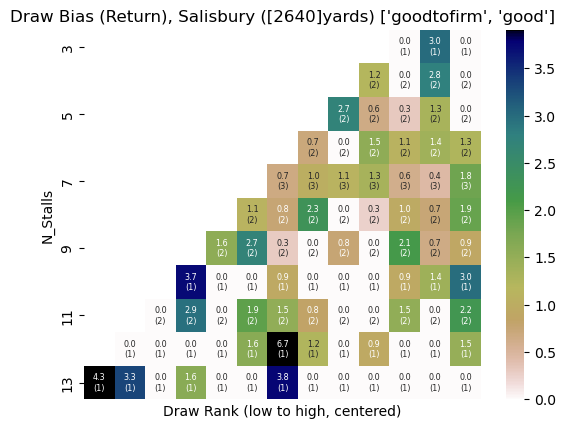

In [169]:
%matplotlib inline

min_ave_supp = 2
course_name = 'Salisbury'

dist = [ 12*220 ]
going = [ 'goodtofirm', 'good' ]


plt.figure()
plt.title('Draw Bias (Return), ' + course_name + ' (' + str(dist) + 'yards) ' + str(going))
hm_data, hm_supp, hm_annot_index, hm_annot_supp = xmast(df, course_name, dist=dist, going=going, 
                                                        stalls='far side', min_ave_supp=min_ave_supp)

sns.heatmap(hm_data.dropna(axis=0, how='all'),
    cmap='gist_earth_r', robust=True,
    # annot=hm_annot_index.dropna(axis=0, how='all'), 
    # annot=hm_annot_supp.dropna(axis=0, how='all'),
            fmt='', annot_kws={'fontsize': 'xx-small'},
    annot=(hm_annot_index + '\n(' + hm_annot_supp + ')').dropna(axis=0, how='all'),
            xticklabels=False, yticklabels=2
    )
plt.show()
# plt.savefig('xmast_' + course_name + '.png')
plt.close()

In [115]:

min_ave_supp = 1
course_name = 'Chester'

for dist in dists:
    for going in goings:

        plt.figure()
        plt.title('Draw Bias (Return), ' + course_name + ' (' + str(dist) + 'yards) ' + str(going))
        hm_data, hm_supp, hm_annot_index, hm_annot_supp = xmast(df, course_name, dist=dist, going=going, 
                                                                stalls='inside', min_ave_supp=min_ave_supp)
        sns.heatmap(hm_data.dropna(axis=0, how='all'),
            cmap='gist_earth_r', robust=True,
            # annot=hm_annot_index.dropna(axis=0, how='all'), 
            # annot=hm_annot_supp.dropna(axis=0, how='all'),
                    fmt='', annot_kws={'fontsize': 'xx-small'},
            annot=(hm_annot_index + '\n(' + hm_annot_supp + ')').dropna(axis=0, how='all'),
                    xticklabels=False, yticklabels=2
            )
        # plt.show()
        plt.savefig('xmast_' + course_name + '_' + str(dist) + '_' + str(going) + '.png')
        plt.close()